<a href="https://colab.research.google.com/github/nishantgott/GDSC_multiclassification/blob/main/GDSCclassification2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multi-Class Classication of network protocols using Neural Network and XGBoost**


In [ ]:
#import all the necessary libraries
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
from matplotlib import pyplot as plt

In [ ]:
#Read and store the dataset using pandas
ds= pd.read_csv('/content/Ml_assignment.csv')

In [ ]:
ds.describe()

Corrupt values
--

After studying the dataset using ds.describe(), we can notice that it consists of many NaN records and inf records. These records are corrupt and might affect the accuracy of the model to produce unexpected results. So, they have to be eliminated.

---

Shuffling
--
When data is collected or organized in a specific order, the order itself might contain patterns or biases that are not representative of the underlying data distribution. Shuffling the data helps remove this bias by ensuring that each data point has an equal chance of being selected during training or validation.




In [ ]:
ds = ds.dropna(subset=['Label'])
ds = ds.replace([np.inf, -np.inf], np.nan).dropna()
ds = ds.dropna(subset=['Flow Packets/s'])

from sklearn.utils import shuffle
ds = shuffle(ds)

In [ ]:
print(ds.columns)

Index(['Unnamed: 0', 'Flow ID', 'Source IP', 'Source Port', 'Destination IP',
       'Destination Port', 'Protocol', 'Timestamp', 'Flow Duration',
       'Total Fwd Packets', 'Total Backward Packets',
       'Total Length of Fwd Packets', 'Total Length of Bwd Packets',
       'Fwd Packet Length Max', 'Fwd Packet Length Min',
       'Fwd Packet Length Mean', 'Fwd Packet Length Std',
       'Bwd Packet Length Max', 'Bwd Packet Length Min',
       'Bwd Packet Length Mean', 'Bwd Packet Length Std', 'Flow Bytes/s',
       'Flow Packets/s', 'Flow IAT Mean', 'Flow IAT Std', 'Flow IAT Max',
       'Flow IAT Min', 'Fwd IAT Total', 'Fwd IAT Mean', 'Fwd IAT Std',
       'Fwd IAT Max', 'Fwd IAT Min', 'Bwd IAT Total', 'Bwd IAT Mean',
       'Bwd IAT Std', 'Bwd IAT Max', 'Bwd IAT Min', 'Fwd PSH Flags',
       'Bwd PSH Flags', 'Fwd URG Flags', 'Bwd URG Flags', 'Fwd Header Length',
       'Bwd Header Length', 'Fwd Packets/s', 'Bwd Packets/s',
       'Min Packet Length', 'Max Packet Length', 'Packet Le

Feature Selection:
--
After analysing each feature, I chose the features which were consistent, and had a measurable impact on classifying the label. The features were :          
['Protocol',
                  'Fwd Packet Length Max','Fwd Packet Length Min','Bwd Packet Length Mean',
                  'SYN Flag Count', 'Flow Duration', 'Total Fwd Packets',
                  'Total Backward Packets', 'Flow Packets/s', 'Flow Bytes/s', 'RST Flag Count', 'Inbound']

In [ ]:
useful_columns = ['Protocol',
                  'Fwd Packet Length Max','Fwd Packet Length Min','Bwd Packet Length Mean',
                  'SYN Flag Count', 'Flow Duration', 'Total Fwd Packets',
                  'Total Backward Packets', 'Flow Packets/s', 'Flow Bytes/s', 'RST Flag Count', 'Inbound']


X = ds[useful_columns]

The label which we have to classify consists of 10 classes. I mapped each class with a number from 0 to 9, in order to give input to the ML model.                             
-
{'BENIGN': 0, 'DrDoS_NTP': 1, 'DrDoS_NetBIOS': 2, 'UDP-lag': 3, 'DrDoS_LDAP': 4, 'DrDoS_SSDP': 5, 'DrDoS_UDP': 6, 'Syn': 7, 'DrDoS_MSSQL': 8, 'WebDDoS': 9}

In [ ]:
word_to_int = {word: idx for idx, word in enumerate(set(ds['Label']))}
word_to_integer_list = [word_to_int[word] for word in ds['Label']]
Y = np.array(word_to_integer_list)

Normalization
--
There are features in the dataset which have widely varying range of values.
In order to make the process of gradient descent regular and more efficient, we have to normalize the data.
It is essential when we are dealing with multiple features.
     I chose Z-score normalization

In [ ]:
columns_to_normalize = ['Fwd Packet Length Max', 'Fwd Packet Length Min', 'Bwd Packet Length Mean',
                        'Flow Duration', 'Total Fwd Packets', 'Total Backward Packets',
                        'Flow Packets/s','Flow Bytes/s']

# Calculate the mean and standard deviation for the selected columns
mean_values = X[columns_to_normalize].mean()
std_values = X[columns_to_normalize].std()

# Apply z-score normalization to the selected columns
X[columns_to_normalize] = (X[columns_to_normalize] - mean_values) / std_values

Label encoding :
--
The feature "Protocol" has 3 categories 0, 6 and 17.
I used a dictionary to map the categories to the values 0,1,2 so that they can be one hot encoded.

{0.0: 0, 17.0: 1, 6.0: 2}

In [ ]:
word_to_int2 = {word: idx for idx, word in enumerate(set(X['Protocol']))}
print(word_to_int2)
word_to_integer_list2 = [word_to_int2[word] for word in X['Protocol']]
X['Protocol']=word_to_integer_list2
print(X['Protocol'].unique())

Splitting the dataset
--

In order to determine how good a model is at predicting (generalizing), it is essential to test it on unseen data which it has not been trained on before.

It will be difficult to assess if the model is overfitted.
So, we can split the dataset into training_data and test data in a ratio 8:2.



IMPORTANT : Split the data randomly after shuffling to prevent incosistencies
                  

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)


(336430, 12)
(84108, 12)
(336430,)
(84108,)


In [ ]:
inputs={
    'Protocol' : keras.layers.Input(shape=(1,), dtype='float32'),
    'Flow Packets/s': keras.layers.Input(shape=(1,), dtype='float32'),
    'SYN Flag Count': keras.layers.Input(shape=(1,), dtype='float32'),
    'Fwd Packet Length Max': keras.layers.Input(shape=(1,), dtype='float32'),
    'Fwd Packet Length Min': keras.layers.Input(shape=(1,), dtype='float32'),
    'Bwd Packet Length Mean': keras.layers.Input(shape=(1,), dtype='float32'),
    'Flow Duration': keras.layers.Input(shape=(1,), dtype='float32'),
    'Total Fwd Packets': keras.layers.Input(shape=(1,), dtype='float32'),
    'Total Backward Packets': keras.layers.Input(shape=(1,), dtype='float32'),
    'Flow Bytes/s' : keras.layers.Input(shape=(1,), dtype='float32'),
    'RST Flag Count' : keras.layers.Input(shape=(1,), dtype='float32'),
    'Inbound' : keras.layers.Input(shape=(1,), dtype='float32')
}

Handling Categorical Features:
--
While handling categorical features, we can't use 0 and 1 directly, as 1 doesn't indicate a higher value than 0.
So we can use one hot vectors to represent 0 and 1.

[1 , 0]  represents 0  
[0 , 1]  represents 1



In [ ]:
protocol_layer = keras.layers.CategoryEncoding(output_mode='one_hot', num_tokens=3)(inputs.get('Protocol'))
SYN_layer = keras.layers.CategoryEncoding(output_mode='one_hot', num_tokens=2)(inputs.get('SYN Flag Count'))
RST_layer = keras.layers.CategoryEncoding(output_mode='one_hot', num_tokens=2)(inputs.get('RST Flag Count'))
inbound_layer = keras.layers.CategoryEncoding(output_mode='one_hot', num_tokens=2)(inputs.get('Inbound'))

Neural Network:
---
I am using 12 keras input layers, each for a different feature.

The input layer instantiates a tensor which consists of all the values in the column of the specific feature.

A tensor is similar to a numpy array, but tensorflow deals with tensors instead of lists or numpy arrays.

In [ ]:
preprocessed_layer= keras.layers.Concatenate()([protocol_layer,
                                                inputs.get('Flow Packets/s'),
                                                SYN_layer,
                                                inputs.get('Fwd Packet Length Max'),
                                                inputs.get('Fwd Packet Length Min'),
                                                inputs.get('Bwd Packet Length Mean'),
                                                inputs.get('Flow Duration'),
                                                inputs.get('Total Fwd Packets'),
                                                inputs.get('Total Backward Packets'),
                                                inputs.get('Flow Bytes/s'),
                                                RST_layer,
                                                inbound_layer
                                                ])

Architecture
--
First layer consists of 32 neurons with relu activation.

Second layer consists of 20 neurons with relu activation.

Third layer consists of 10 neurons with softmax activation.

---
I chose 10 neurons for third layer because there are 10 classes for label. Each neuron of the last layer will output a value between 0 and 1. The neuron with the highest output will be predicted.



In [ ]:
dense_output=keras.layers.Dense(units=32,activation="relu")(preprocessed_layer)
dense_output=keras.layers.Dense(units=20,activation="relu")(dense_output)
dense_output=keras.layers.Dense(units=10,activation="softmax")(dense_output)

outputs = {
  'dense_output': dense_output
}

Configuring the model
--
Before training the model, we configure it using model.compile.
Here, we specify optimizer, loss and metrics to assess the model's performance.


*   Adams optimzer is a standard optimzer that changes the learning rate
accordingly to the rate of gradient descent.
*   Sparse_categorical_crossentropy is used when classifying multiple classes with the help of softmax activation function. Since the label is in the form of categories and not one hot encoded, we are using sparse.

*   Accuracy is the ratio of the number of times the model gives a correct prediction to the total number of predictions.








In [ ]:
 my_model = tf.keras.Model(inputs=inputs,outputs=outputs)

 my_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
                loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])

In [ ]:
features = {name:np.array(value) for name, value in X_train.items()}

Training the model
--

The neural network is trained on the data for 5 epochs. i.e it minimizes loss by iterating through all the the training examples exactly 5 times

Since we are dealing with a very large dataset, it is better if we divide each epoch into batches of fixed size. This will lead to faster convergence of loss and smoother gradients.

In [ ]:
my_model.fit(x=features, y=Y_train, batch_size=32, epochs=5, shuffle=True, validation_split=0.2)

Epoch 1/5
8411/8411 [==============================] - 18s 2ms/step - loss: 0.6487 - accuracy: 0.7377 - val_loss: 0.5769 - val_accuracy: 0.7444
Epoch 2/5
8411/8411 [==============================] - 19s 2ms/step - loss: 0.5581 - accuracy: 0.7489 - val_loss: 0.5596 - val_accuracy: 0.7545
Epoch 3/5
8411/8411 [==============================] - 16s 2ms/step - loss: 0.5537 - accuracy: 0.7512 - val_loss: 0.5732 - val_accuracy: 0.7480
Epoch 4/5
8411/8411 [==============================] - 17s 2ms/step - loss: 0.5462 - accuracy: 0.7532 - val_loss: 0.5546 - val_accuracy: 0.7548
Epoch 5/5
8411/8411 [==============================] - 17s 2ms/step - loss: 0.5337 - accuracy: 0.7547 - val_loss: 0.5387 - val_accuracy: 0.7498


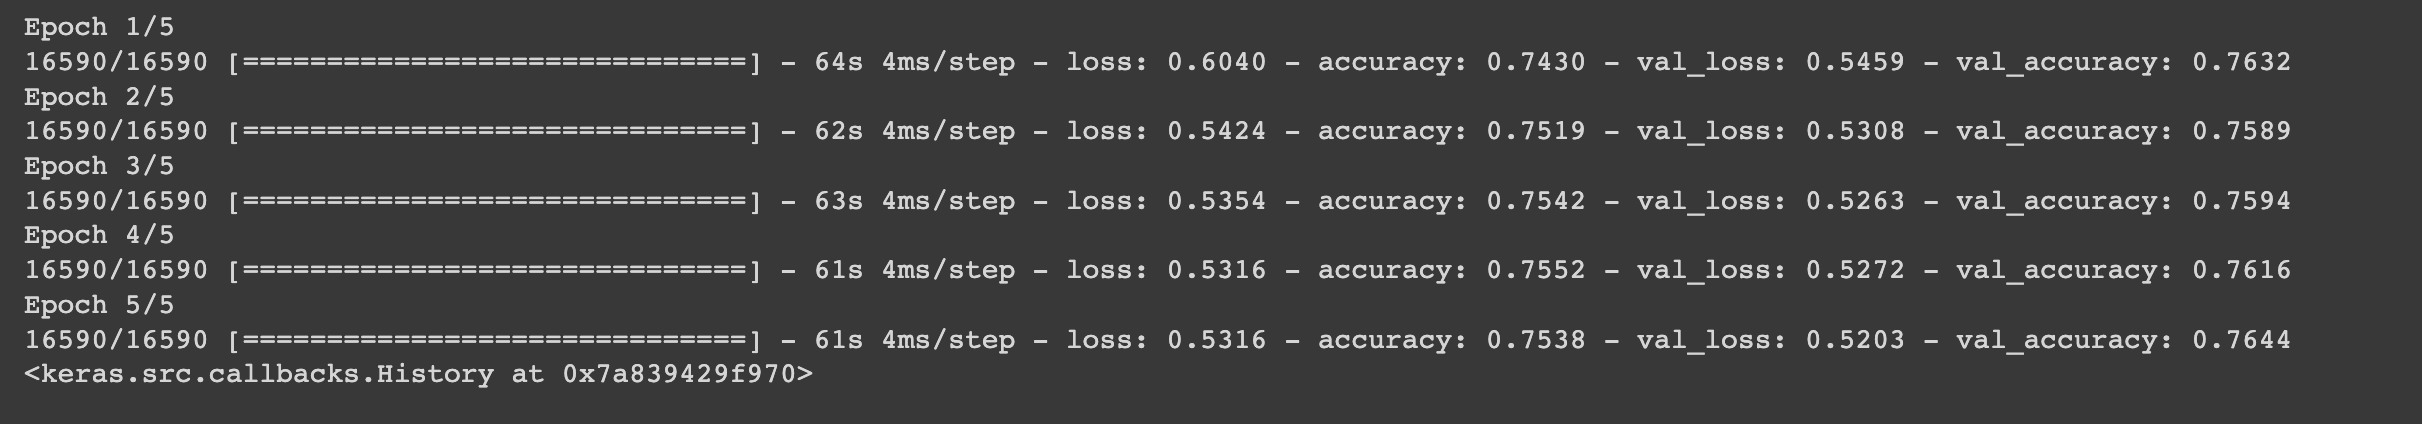

In [ ]:
my_model.summary()

Evaluating the model.
--
We can test the model on test data and compare the predictions of the label to the true values of the table to determine accuracy.
The accuracy of this model is 0.7584146857261658.

In [ ]:
test_features = {name:np.array(value) for name, value in X_test.items()}

my_model.evaluate(test_features, Y_test, verbose=0)

[0.5421976447105408, 0.7584146857261658]

In [ ]:
Y_pred = my_model.predict(test_features)


In [ ]:
print(np.argmax(Y_pred['dense_output'][4]))
# pp = np.array(map(np.argmax(), Y_pred['dense_output']))
# pp = np.array(i:np.argmax(Y_pred['dense_output'][i]))
ppp=[]
for i in Y_pred['dense_output']:
  ppp.append(np.argmax(i))
ppp=np.array(ppp)
Y_pred=ppp

2


Classifier Metrics
--
We can use different classifier metrics like precision, recall, f-score to assess how well that particular class is recognized and predicted by the model.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Y_true=Y_test

# Calculate and display different classification metrics class-wise
class_labels = set(Y_true)  # Assuming class labels are integers 0 to 9

accuracy = accuracy_score(Y_true, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_metrics = classification_report(Y_true, Y_pred, target_names=[f'Class {label}' for label in class_labels])
print("Classification Report:\n", class_metrics)

conf_matrix = confusion_matrix(Y_true, Y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")




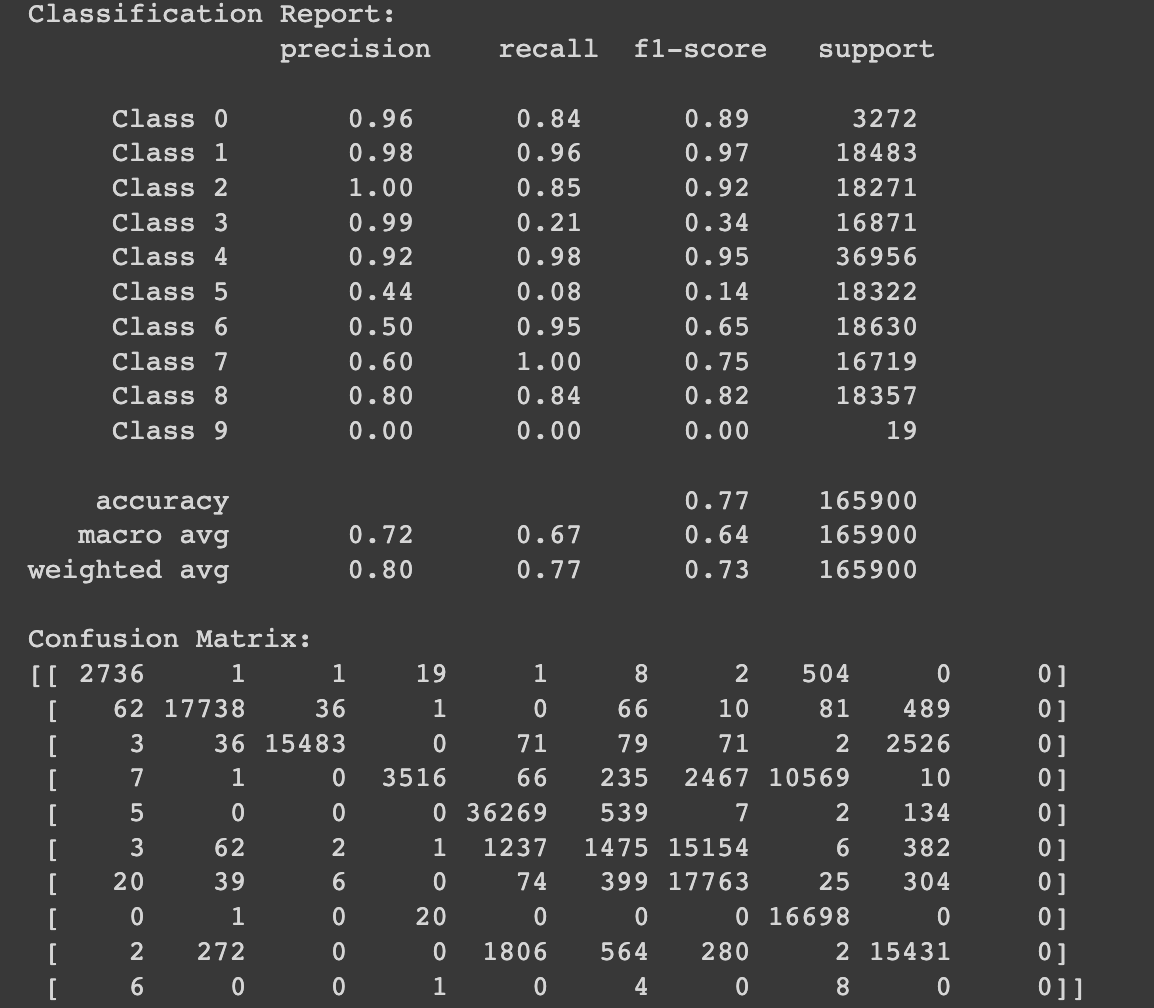

The proportion of actual positives that are identified correctly is given by recall , where as the proportion of positive identifications that was actually correct is precision.



*   We can adjust the classification threshold to increase or decrease recall and precision.
*   Both are in a tug of war, increase in precision leads to decrease in recall and viceversa.


*   Decreasing the value of classification threshold can help in increasing recall for a particular class.
*   So it is best to consider f-score as it is the mean of precision and recall.





---


---








# Multi-Class Classication of network protocols using XGBoost


In [ ]:
from sklearn.preprocessing import LabelEncoder
for i in ds.columns:
    if ds[i].dtype == 'object':
      ds[i] = LabelEncoder().fit_transform(ds[i])

Feature Selection
--
This code uses a DecisionTreeClassifier to assess the importance of each feature in the dataset X2 and then selects the top 20 most important features based on their importance scores.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
X2 = ds.iloc[:, :86]
dt = DecisionTreeClassifier()
dt.fit( X2, Y)


num_features_to_select = 20
feature_importances = dt.feature_importances_
useful_features = X2.columns[np.argsort(feature_importances)[-num_features_to_select:]]

print(useful_features)

X2=X2[useful_features]

Index(['Flow IAT Max', 'Protocol', 'Fwd IAT Min', 'Fwd IAT Max', 'Fwd IAT Std',
       'Fwd IAT Mean', 'Fwd IAT Total', 'Source Port', 'Flow IAT Min',
       'Bwd IAT Total', 'Destination Port', 'min_seg_size_forward',
       'Bwd Header Length', 'URG Flag Count', 'Bwd Packet Length Mean',
       'Flow Packets/s', 'Init_Win_bytes_backward', 'Flow ID',
       'Min Packet Length', 'Timestamp'],
      dtype='object')


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y, test_size=0.2, random_state=42)

XGBoost
--
It is a modified version of Random Forest Classifier called XGBoost which is trained on the dataset

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

clf = xgb.XGBClassifier(learning_rate=0.1, n_estimators=100, max_depth=3)

clf.fit(X_train, Y_train)

Y_pred = clf.predict(X_test)

accuracy = accuracy_score(Y_test, Y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 100.00%


Classifier Metrics
--
We can use the same Classifier metrics to check if XGBoost improved our results.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

Y_true=Y_test

# Calculate and display different classification metrics class-wise
class_labels = set(Y_true)  # Assuming class labels are integers 0 to 9

accuracy = accuracy_score(Y_true, Y_pred)
print(f"Accuracy: {accuracy:.2f}")

class_metrics = classification_report(Y_true, Y_pred, target_names=[f'Class {label}' for label in class_labels])
print("Classification Report:\n", class_metrics)

conf_matrix = confusion_matrix(Y_true, Y_pred)
print(f"Confusion Matrix:\n{conf_matrix}")

Accuracy: 1.00
Classification Report:
               precision    recall  f1-score   support

     Class 0       1.00      1.00      1.00      1199
     Class 1       1.00      1.00      1.00     13861
     Class 2       1.00      1.00      1.00      6865
     Class 3       1.00      1.00      1.00      7029
     Class 4       1.00      1.00      1.00      6921
     Class 5       1.00      1.00      1.00      6883
     Class 6       1.00      1.00      1.00      6988
     Class 7       1.00      1.00      1.00      6283
     Class 8       1.00      1.00      1.00      6483
     Class 9       1.00      0.88      0.93         8

    accuracy                           1.00     62520
   macro avg       1.00      0.99      0.99     62520
weighted avg       1.00      1.00      1.00     62520

Confusion Matrix:
[[ 1199     0     0     0     0     0     0     0     0     0]
 [    0 13861     0     0     0     0     0     0     0     0]
 [    0     0  6865     0     0     0     0     0     0   

We can see that, instead of training the model on manually selected features, by using Decision Tree Classifier, we can get much better results for every class of Label.
By using the manually selected features, I got an accuracy of 77.7 using XGBoost compared to 100 while using features selected by Decision Tree Classifier.